In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [6]:
def option_chains(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options
    chains = pd.DataFrame()

    for expiration in expirations:
        option = asset.option_chain(expiration)
        
        calls = option.calls
        calls['optionType'] = "call"
        
        puts = option.puts
        puts['optionType'] = "put"
        
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        chains = pd.concat([chains, chain])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains

In [7]:
aapl = option_chains("AAPL")
aapl_calls = aapl[aapl["optionType"] == "call"]

aapl_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration
0,AAPL231124C00050000,2023-11-22 16:20:34+00:00,50.0,141.35,141.1,141.5,0.0,0.0,12.0,6,7.820313,True,REGULAR,USD,call,2023-11-24 23:59:59,2
1,AAPL231124C00075000,2023-11-03 18:07:22+00:00,75.0,100.21,116.1,116.5,0.0,0.0,1.0,0,5.554691,True,REGULAR,USD,call,2023-11-24 23:59:59,2
2,AAPL231124C00090000,2023-11-01 14:00:00+00:00,90.0,81.35,101.1,101.5,0.0,0.0,1.0,0,4.546879,True,REGULAR,USD,call,2023-11-24 23:59:59,2
3,AAPL231124C00095000,2023-10-25 14:10:07+00:00,95.0,77.10,96.1,96.5,0.0,0.0,NaN,0,4.246098,True,REGULAR,USD,call,2023-11-24 23:59:59,2
4,AAPL231124C00100000,2023-11-10 19:30:52+00:00,100.0,85.83,91.1,91.5,0.0,0.0,7.0,7,3.960938,True,REGULAR,USD,call,2023-11-24 23:59:59,2


<AxesSubplot: title={'center': 'Implied Volatility Skew'}, xlabel='strike'>

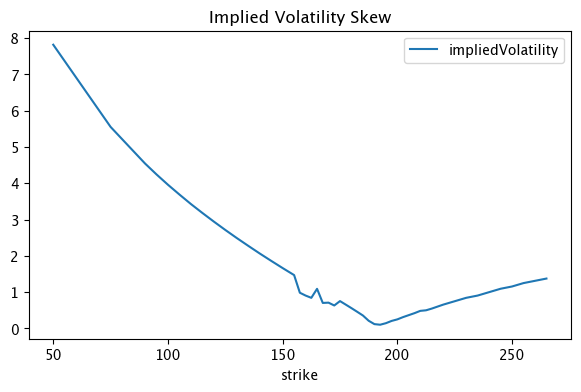

In [9]:
calls_at_expiry = aapl_calls[aapl_calls["expiration"] == "2023-11-24 23:59:59"]
# filter out low vols
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(title="Implied Volatility Skew", figsize=(7, 4))

<AxesSubplot: title={'center': 'Implied Volatility Term Structure'}, xlabel='expiration'>

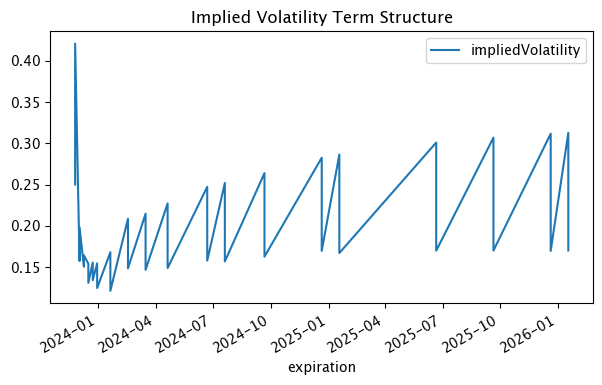

In [10]:
calls_at_strike = aapl[aapl["strike"] == 200.0]
# filter out low vols
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]
filtered_calls_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(title="Implied Volatility Term Structure", figsize=(7, 4))

In [11]:
def plot_implied_vol_surface(ticker):
    option = option_chains(ticker)
    calls = option[option["optionType"] == "call"]
    surface = (calls[['daysToExpiration', 'strike', 'impliedVolatility']].pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration').dropna())

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x, y)
    ax.set_xlabel('Days to expiration')
    ax.set_ylabel('Strike price')
    ax.set_zlabel('Implied volatility')
    ax.set_title(f'{ticker} calls implied volatility surface')
    ax.plot_surface(X, Y, z)

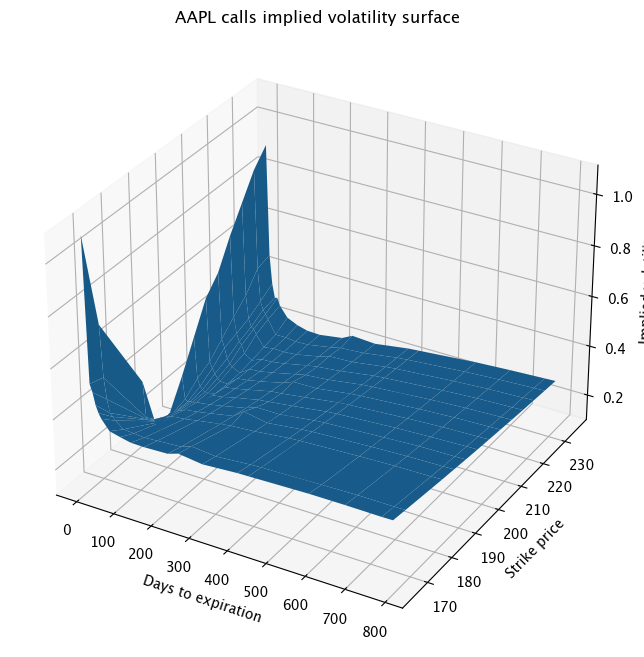

In [12]:
plot_implied_vol_surface('AAPL')